# Proyecto #3: Clustering - Inteligencia artificial

## Integrantes

- Pedro Domínguez
- Luis Chahua
- Carlos Guerrero

## Librerías

In [29]:
import pandas as pd
import numpy as np
import os

#Librerías que permitirá reducir dimensiones
import pywt
import pywt.data
from sklearn.decomposition import PCA

#Librerías para lectura/edición de imágenes
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray

#Librerías para generar gráficas
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tabulate import tabulate

#Librerías para realizar métricas
from sklearn.metrics.cluster import homogeneity_score, completeness_score

#Librerías para clustering
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram

## Lectura de datos

In [30]:
dataset_txt = "../data/dataset_tissue.txt"

dataset = pd.read_csv(dataset_txt).transpose()
dataset = dataset.drop(index = "Unnamed: 0", axis = 0).to_numpy()
#dataset.shape

types_txt = "../data/clase.txt"
true_labels = pd.read_csv(types_txt, index_col = 0).to_numpy().flatten()
#types.shape

In [31]:
#Showing the dataset and types dimension
dataset.shape, true_labels.shape

((189, 22215), (189,))

In [32]:
#Showing unique labels
unique_labels = np.unique(true_labels)
print(unique_labels)

# Encoding labels 
label_encoding = {label:i for i, label in enumerate(unique_labels)}
true_labels = [label_encoding[true_label] for true_label in true_labels]

['cerebellum' 'colon' 'endometrium' 'hippocampus' 'kidney' 'liver'
 'placenta']


## Initialization

### Wavelets families

In [33]:
discrete_family_wavelets = ['haar', 'bior', 'coif', 'rbio', 'sym', 'db', 'dmey']
discrete_wavelets = {family:pywt.wavelist(family) for family in discrete_family_wavelets}

### Number of clusters

In [34]:
n_clusters = list(range(2, 11))

### Dimensionality reduction

In [35]:
def reduce_thread_dimension(thread, wavelet = 'haar', cuts = 2):
  for i in range(cuts):
    (thread, cD) = pywt.dwt(thread, wavelet)
  return thread

def vectorize(matrix):
  return matrix.flatten()

def reduce_dataset_dimensionality(dataset, wavelet = 'haar', cuts = 2):
  
  temp = []
  #data_Y = []

  for features in dataset:
      
      #letter = features[0]
      #data_Y.append(letter)
      features = reduce_thread_dimension(features, wavelet, cuts)
      features = vectorize(features)
      temp.append(features)

  return np.array(temp) #data_Y

In [36]:
dataset = reduce_dataset_dimensionality(dataset, wavelet='haar')
dataset.shape

(189, 5554)

## K-mean implementation

In [37]:
def get_first_centroids(dataset, n_clusters):
    indexes = np.random.randint(len(dataset), size=n_clusters)

    centroids = np.zeros((n_clusters, len(dataset[0])))
    
    for i, index in enumerate(indexes):
        centroids[i] = dataset[index]
        
    return centroids

In [38]:
def get_centroid_label(thread, centroids):
    min_dist = float('inf')
    label = 0
    
    for i, centroid in enumerate(centroids):
        dist = np.linalg.norm(centroid - thread)

        if min_dist > dist:
            min_dist = dist
            label = i

    return label

In [39]:
def update_centroids(labels, dataset, n_clusters):
    temp = {label: np.array([]) for label in np.unique(labels)}

    for label in labels:
        temp[label] = np.append(temp[label], dataset[label])
    
    centroids = np.zeros((n_clusters, len(dataset[0])))

    for label, threads in temp.items():
         centroids[label] = np.mean(threads, axis=0)

    return centroids

In [40]:
def compare_centroids(centroids, next_centroids):
    for centroid, next_centroid in zip(centroids, next_centroids):
        close_enough = np.allclose(centroid, next_centroid)

        if not close_enough:
            return next_centroids, close_enough
    
    return next_centroids, close_enough

In [41]:
def kmeans(dataset, n_clusters = 7, iter = 100):
    labels = np.zeros(len(dataset), dtype=np.int8)
    centroids = get_first_centroids(dataset, n_clusters)
    close_enough = False

    #while not close_enough:
    for it in range(iter):
        for i, thread in enumerate(dataset):
            labels[i] = get_centroid_label(thread, centroids)

        next_centroids = update_centroids(labels, dataset, n_clusters)
        centroid, close_enough = compare_centroids(centroids, next_centroids)

        #print(close_enough)

    return labels

In [42]:
def get_score(dataset, true_labels):
    predicted_labels = kmeans(dataset)
    
    iterations = 10
    result = 0
    
    for i in range(iterations):
        result += homogeneity_score(true_labels, predicted_labels)

    return result / iterations

## Experimentation

#### Silhouette

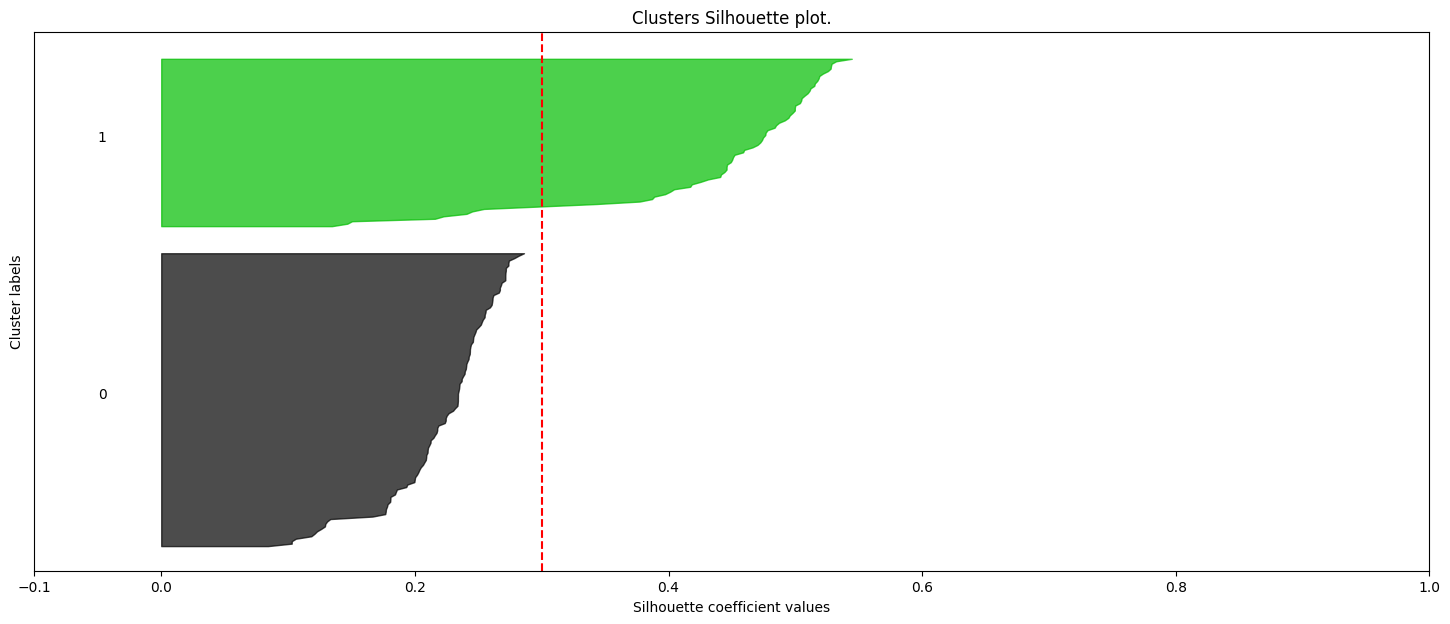

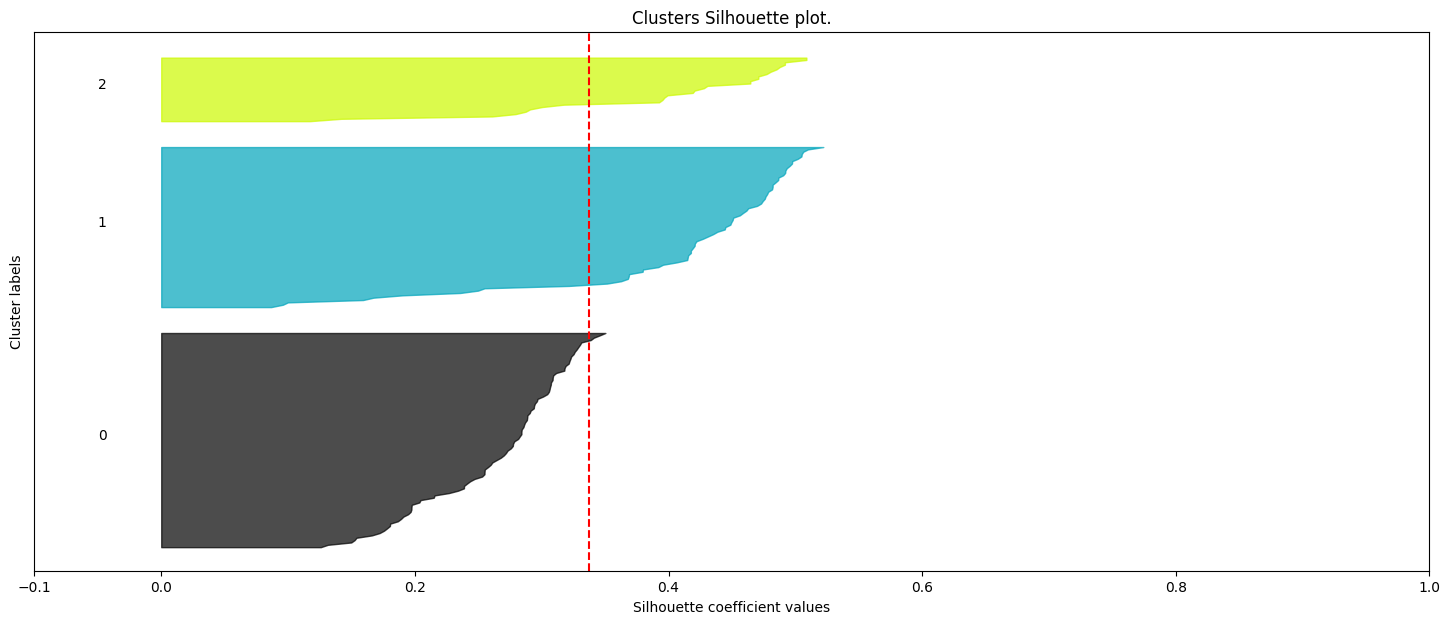

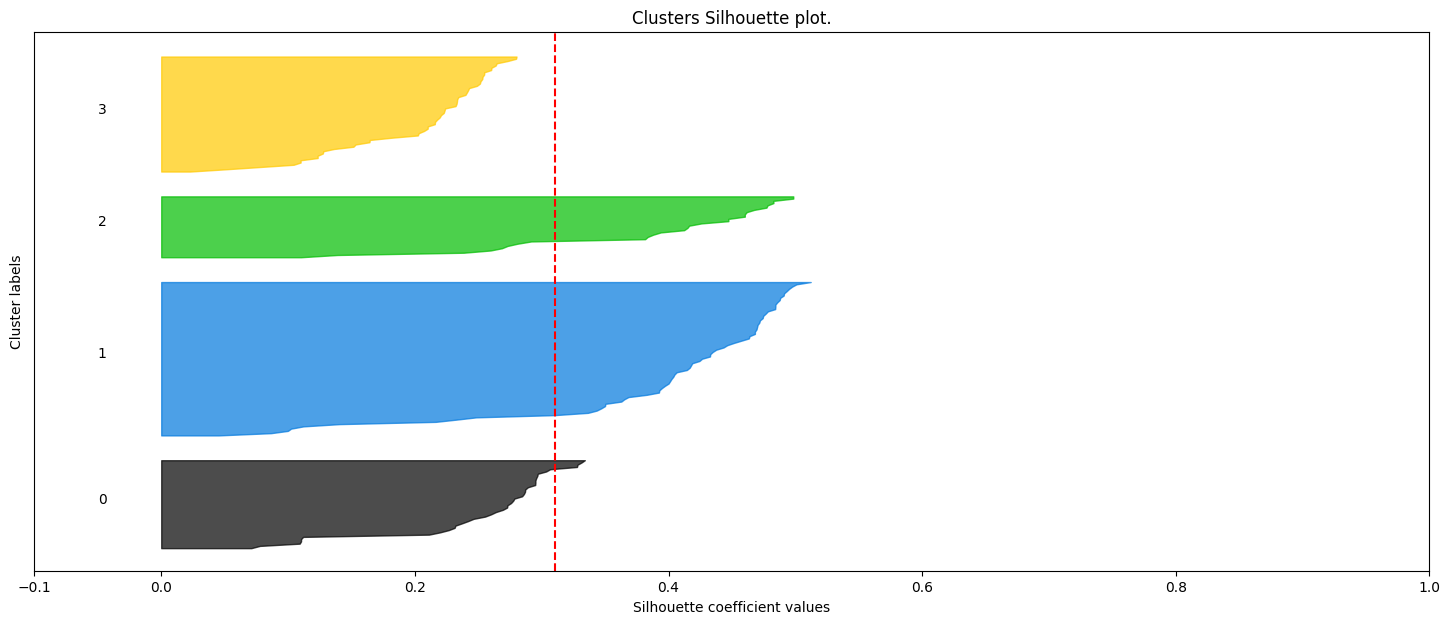

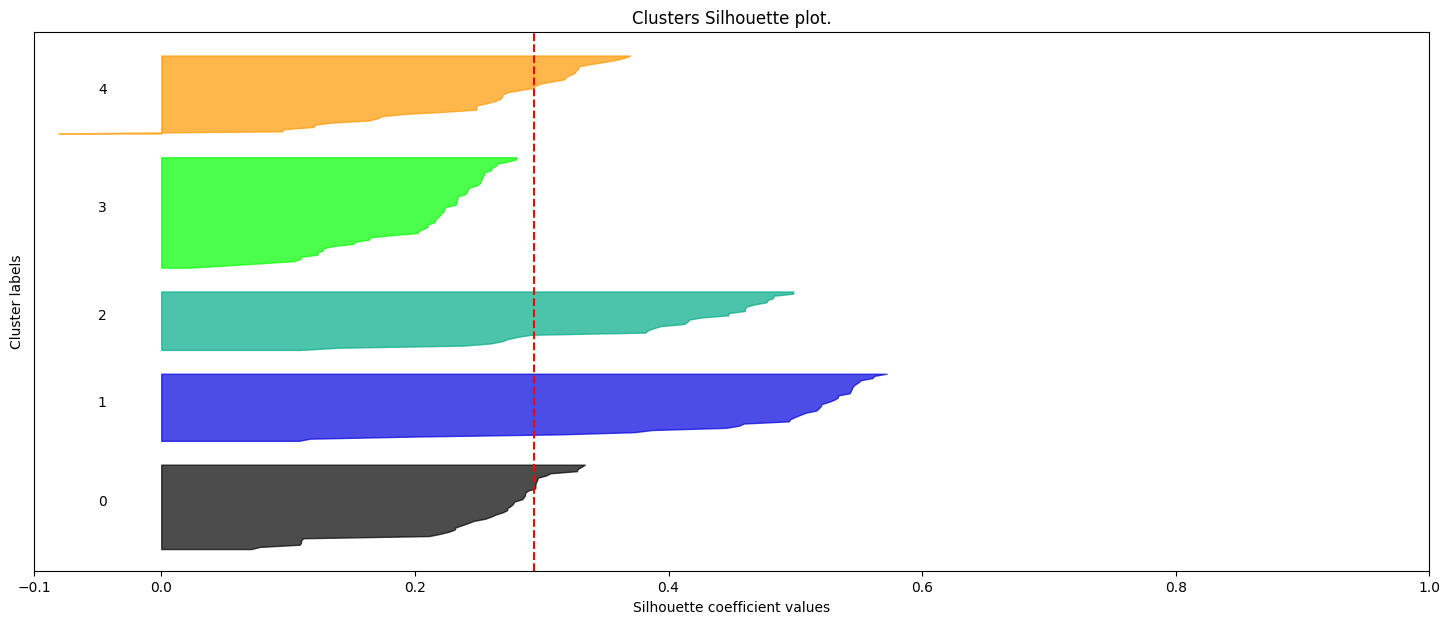

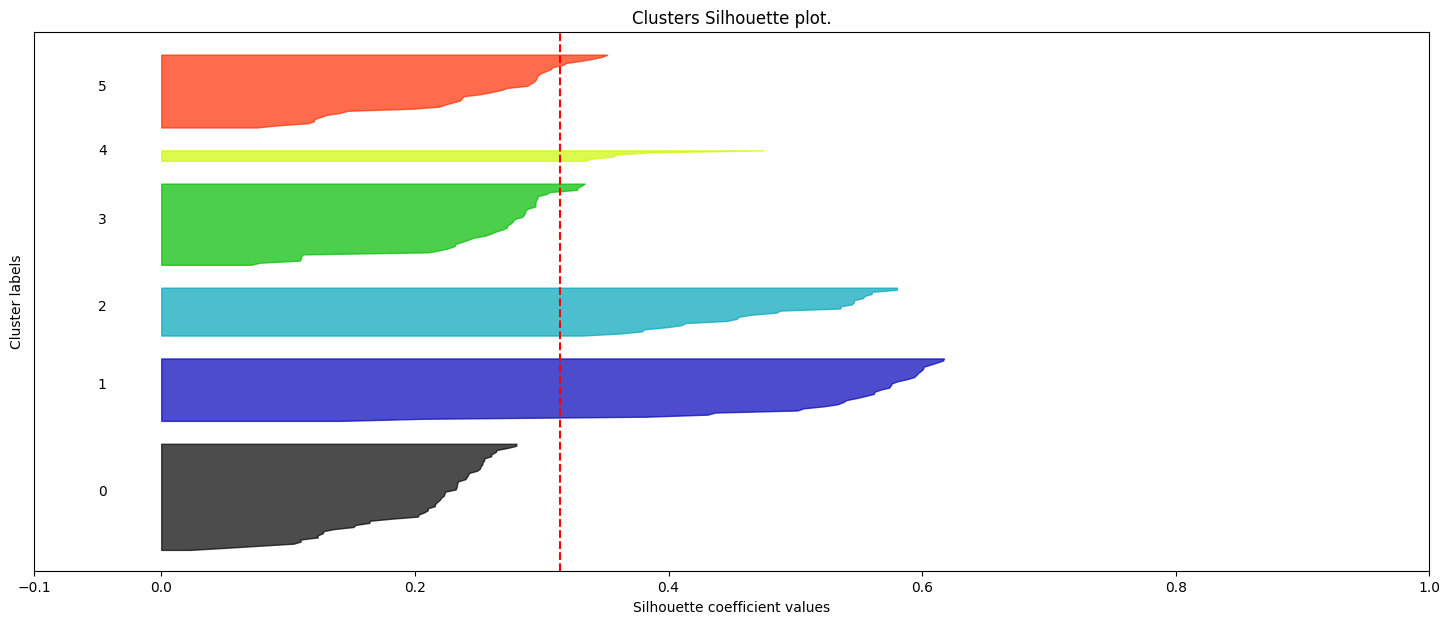

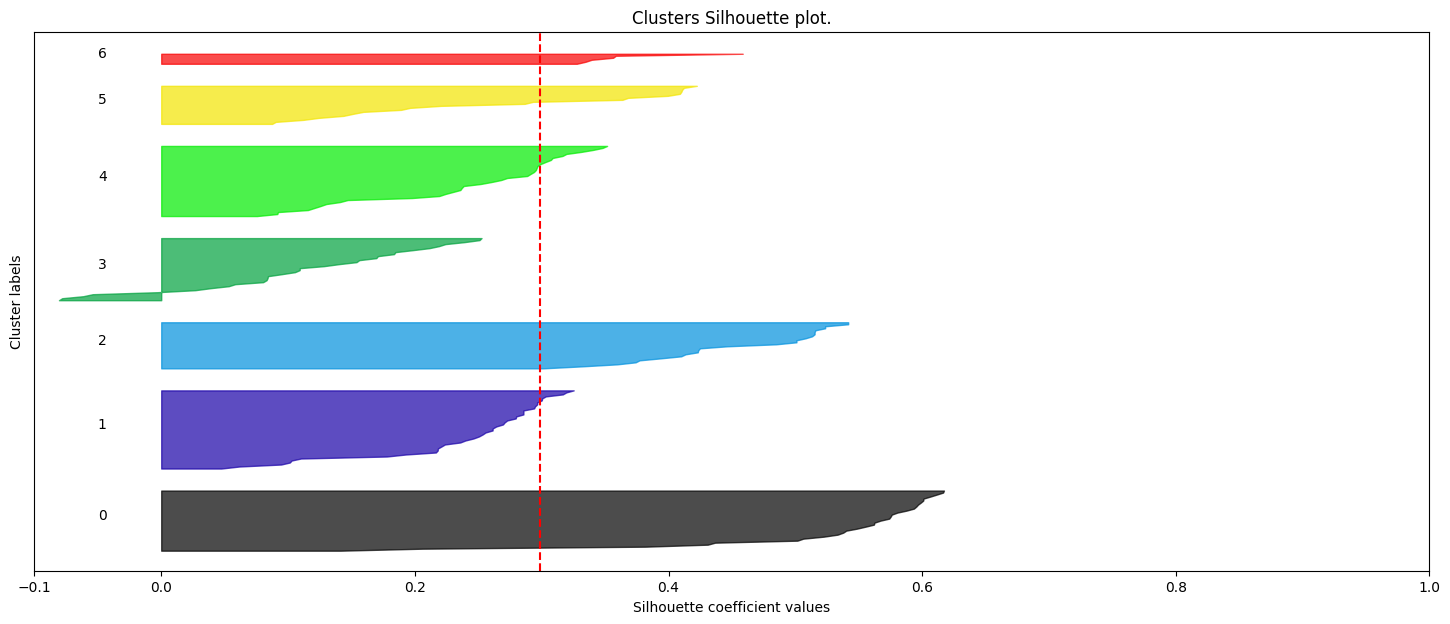

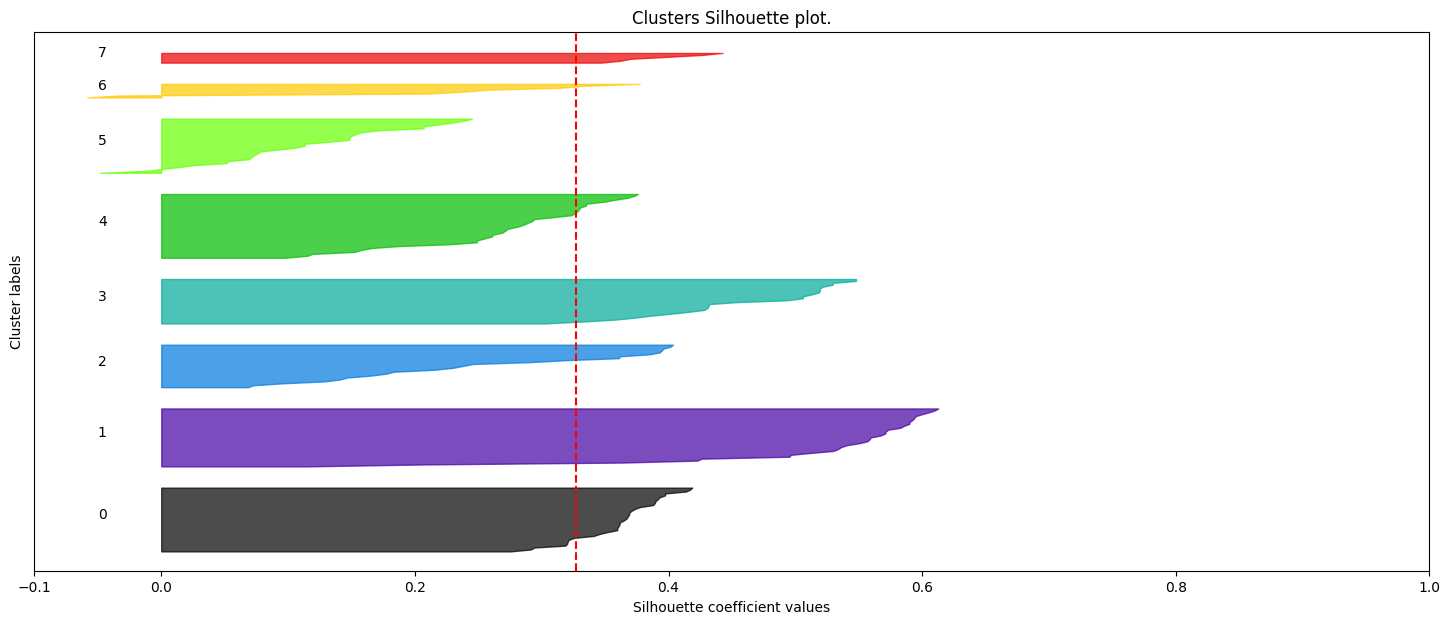

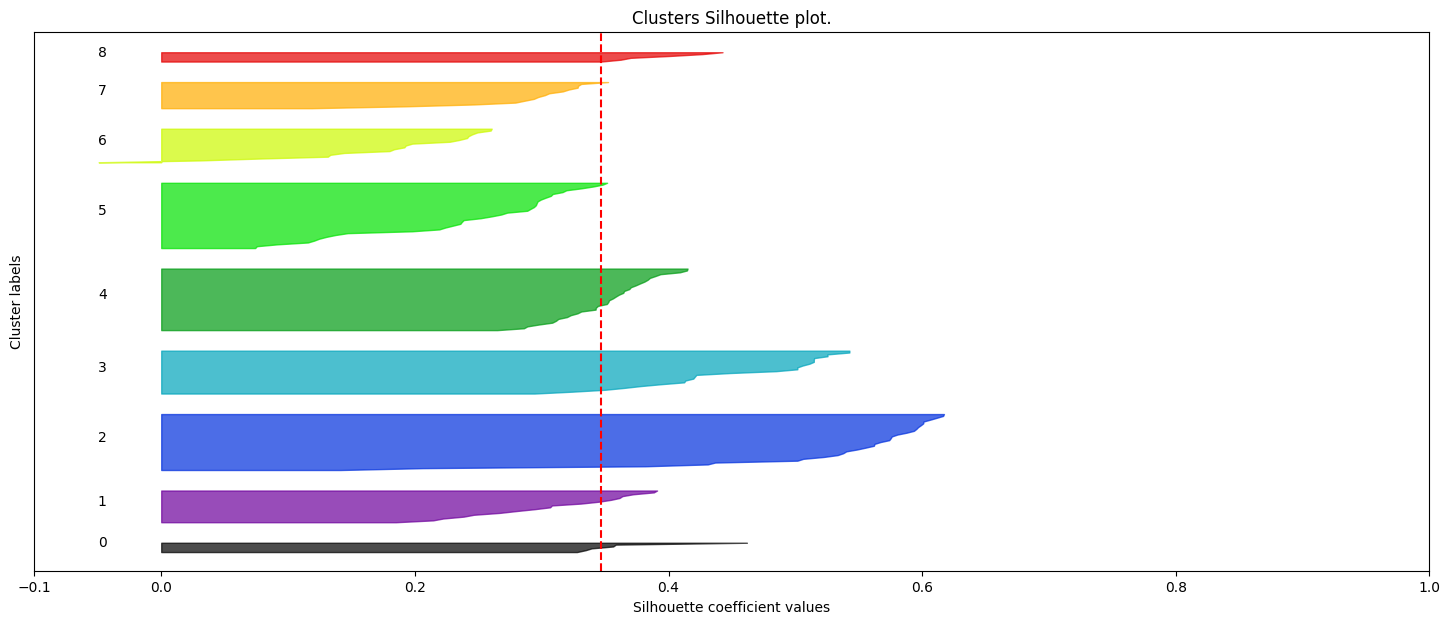

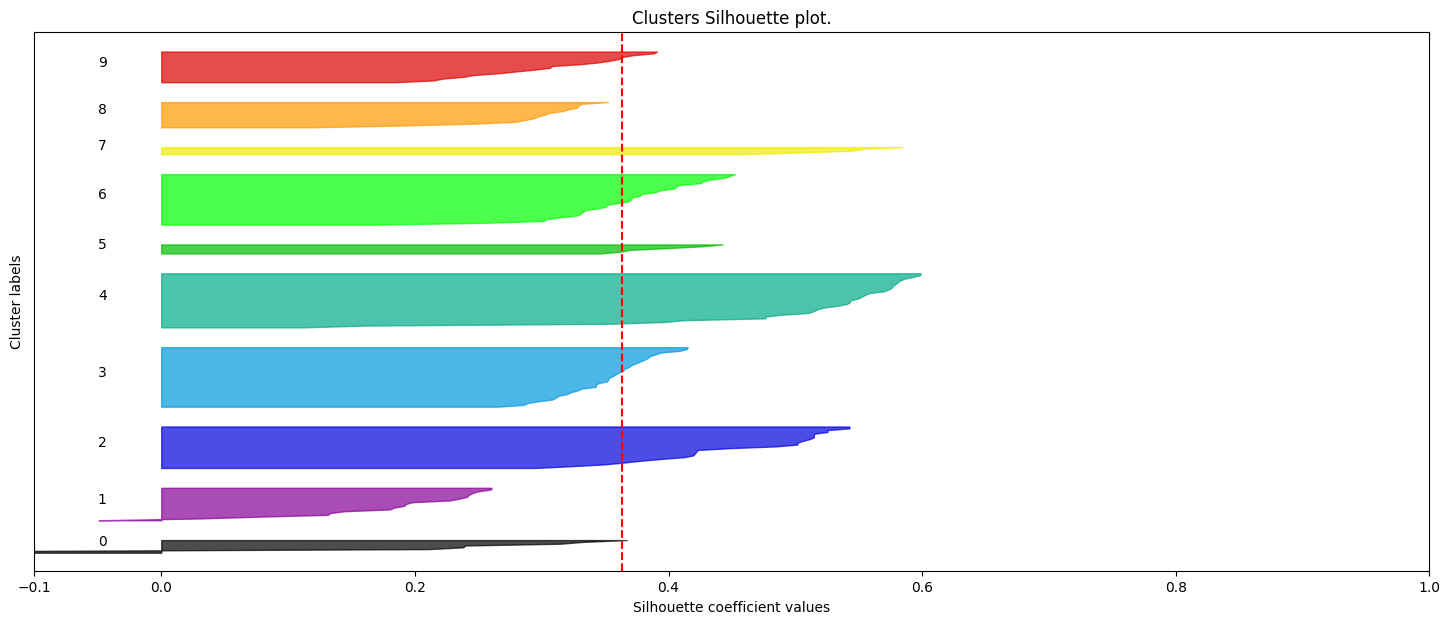

In [43]:
for n_cluster in n_clusters:
    fig, ax1 = plt.subplots()

    #Recommended window, axis size and ticks by Sklearn 
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(dataset) + (n_cluster + 1) * 10])
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    y_lower = 10

    #K-means clustering
    clusterer_KM = KMeans(n_clusters=n_cluster, random_state=10)
    cluster_labels_KMM = clusterer_KM.fit_predict(dataset)

    #Silhouette scoring
    silhouette_avg = silhouette_score(dataset, cluster_labels_KMM)
    sample_silhouette_values = silhouette_samples(dataset, cluster_labels_KMM)


    for i in range(n_cluster):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels_KMM == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = len(ith_cluster_silhouette_values)
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_cluster)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Recommended settings by Sklearn
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 

    ax1.set_title("Clusters Silhouette plot.")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster labels")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

#### Scoring (Manual implementation)

In [318]:
get_score(dataset, true_labels)

0.9058070549053656

#### Scoring (Library)

In [16]:
for n_cluster in n_clusters:
    clusterer = KMeans(n_clusters=n_cluster, random_state=7)
    cluster_labels = clusterer.fit_predict(dataset)
    h_score = homogeneity_score(true_labels, cluster_labels)
    c_score = completeness_score(true_labels, cluster_labels)
    print(h_score, c_score)

0.3573018980419071 1.0
0.5223713715037357 0.9583119819490076
0.7038043453541009 0.9687225622482004
0.6981107635445687 0.880541632627086
0.7926988184001634 0.8684113969227452
0.8905205793054277 0.8923846923441209
0.9392266109912564 0.8973927458965404
0.9392266109912562 0.8384879511975066
0.9680532550511048 0.8269412373198856


#### Dendogram

In [45]:
# Dendogram plotting taken from Sklearn. This function creates a linkage matrix for plotting
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack( [model.children_, model.distances_, counts] ).astype(float)
    dendrogram(linkage_matrix, **kwargs)

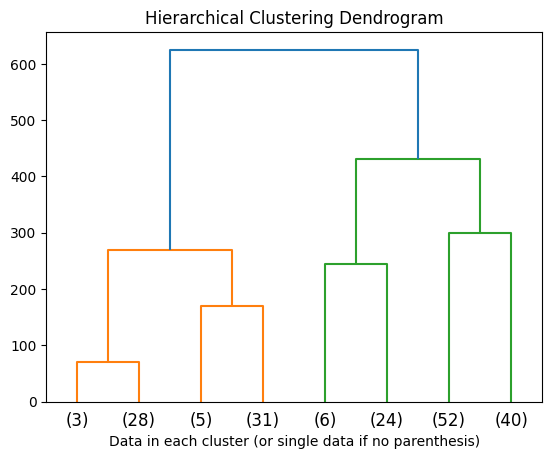

In [46]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(dataset)

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="level", p=2)

plt.xlabel("Data in each cluster (or single data if no parenthesis)")
plt.show()